In [43]:
!pip install PySpecKit
!pip install spectral-cube 

INFO: Setting xmin,xmax from keywords 4847.47,4877.47 [pyspeckit.spectrum.interactive]
Hα line observed center: 6566.47 Å
Hα redshift: 0.000240
Hα radial velocity: 72.1 km/s

Hβ line observed center: 4862.89 Å
Hβ redshift: 0.000327
Hβ radial velocity: 98.1 km/s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


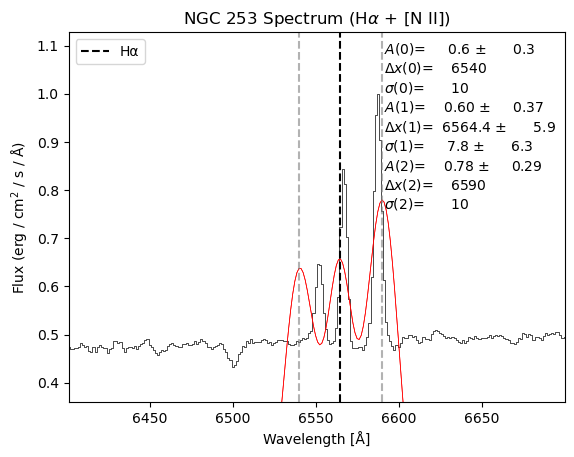

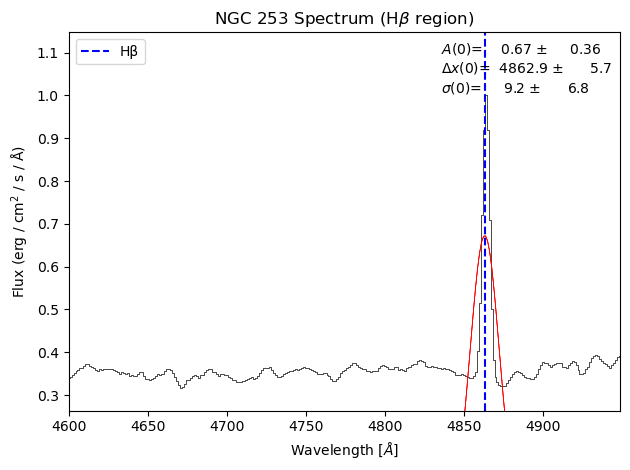

<Figure size 640x480 with 0 Axes>

In [106]:
import pyspeckit as psk
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits
from astropy.io.fits import Header
from pyspeckit.spectrum.units import SpectroscopicAxis

wavelength_ha, flux_ha = np.loadtxt('/Users/rileylutz/Downloads/ngc253_ha.tab', unpack=True) 
wavelength_hb, flux_hb = np.loadtxt('/Users/rileylutz/Downloads/ngc253_hb.tab', unpack=True) 

header_ha = Header({'BUNIT':'erg / (cm^2 s angstrom)', 'XUNITS': 'angstroms', 'OBJECT': 'NGC253 H-alpha'}) 
header_hb = Header({'BUNIT':'erg / (cm^2 s angstrom)', 'XUNITS': 'angstroms', 'OBJECT': 'NGC253 H-beta'})

xarr_ha = SpectroscopicAxis(wavelength_ha, unit='angstrom')
xarr_hb = SpectroscopicAxis(wavelength_hb, unit='angstrom') 

spectrum_ha = psk.Spectrum(data=flux_ha, xarr=xarr_ha, xunit='angstroms', unit='erg / (cm^2 s angstrom)', header=header_ha)
spectrum_hb = psk.Spectrum(data=flux_hb, xarr=xarr_hb, xunit='angstroms', unit='erg / (cm^2 s angstrom)', header=header_hb)

spectrum_ha.data /= np.max(spectrum_ha.data)
spectrum_hb.data /= np.max(spectrum_hb.data)

spectrum_ha.plotter()
spectrum_ha.plotter.axis.set_ylabel("Flux (erg / cm$^2$ / s / Å)") 
spectrum_ha.plotter.axis.set_xlabel("Wavelength [Å]") 
spectrum_ha.plotter.axis.set_title("NGC 253 Spectrum (H$\\alpha$ + [N II])")

guesses = [
    0.2, 6548.0, 2.5,   # [N II] 6548
    1.0, 6563.0, 3.0,   # Hα
    0.4, 6583.0, 2.5    # [N II] 6583
]

spectrum_ha.specfit(fittype='gaussian', guesses=guesses, limited=[(True,True)]*9,
                    limits=[(0,2), (6540,6555), (0,10),
                            (0,2), (6555,6570), (0,10),
                            (0,2), (6570,6590), (0,10)])
spectrum_ha.specfit.plot_fit(color='red')

fitted = spectrum_ha.specfit.modelpars
center_NII_6548 = fitted[1]
center_Ha = fitted[4]
center_NII_6583 = fitted[7]

rest_lambda_ha = 6562.8
z_ha = (center_Ha - rest_lambda_ha) / rest_lambda_ha
v_ha = z_ha * 3e5

ax = spectrum_ha.plotter.axis
ax.axvline(center_NII_6548, color='gray', linestyle='--', alpha=0.6)
ax.axvline(center_Ha, color='black', linestyle='--', label='Hα')
ax.axvline(center_NII_6583, color='gray', linestyle='--', alpha=0.6)
ax.legend()

spectrum_hb.plotter()
spectrum_hb.plotter.axis.set_ylabel("Flux (erg / cm$^2$ / s / Å)") 
spectrum_hb.plotter.axis.set_xlabel("Wavelength [$\\AA$]") 
spectrum_hb.plotter.axis.set_title("NGC 253 Spectrum (H$\\beta$ region)")

expected_hb_center = 4861.3 * (1 + z_ha)
fit_window_min = expected_hb_center - 15
fit_window_max = expected_hb_center + 15

spectrum_hb.specfit(fittype='gaussian',
                    guesses=[0.8, expected_hb_center, 3.0],
                    xmin=fit_window_min,
                    xmax=fit_window_max,
                    limited=[(True, True), (True, True), (True, True)],
                    limits=[(0, 2), (fit_window_min, fit_window_max), (0.5, 10)])
spectrum_hb.specfit.plot_fit(color='blue', linewidth='0.5')

spectrum_ha.plotter.axis.legend(loc='upper left')
spectrum_hb.plotter.axis.legend(loc='upper left')

fit_center_hb = spectrum_hb.specfit.modelpars[1]
rest_lambda_hb = 4861.3
z_hb = (fit_center_hb - rest_lambda_hb) / rest_lambda_hb
v_hb = z_hb * 3e5

print(f"Hα line observed center: {fit_center_ha:.2f} Å")
print(f"Hα redshift: {z_ha:.6f}")
print(f"Hα radial velocity: {v_ha:.1f} km/s\n")

print(f"Hβ line observed center: {fit_center_hb:.2f} Å")
print(f"Hβ redshift: {z_hb:.6f}")
print(f"Hβ radial velocity: {v_hb:.1f} km/s")


spectrum_hb.plotter.axis.axvline(fit_center_hb, color='blue', linestyle='--', label='Hβ')
spectrum_hb.plotter.axis.legend()
spectrum_hb.specfit.plot_fit(color='blue')
spectrum_hb.plotter.axis.legend(loc='upper left')

plt.tight_layout() 
plt.show()
plt.savefig("my_plot.png")

Original CTYPE3: FREQ
Original CUNIT3: Hz


Cube is a Stokes cube, returning spectral cube for I component


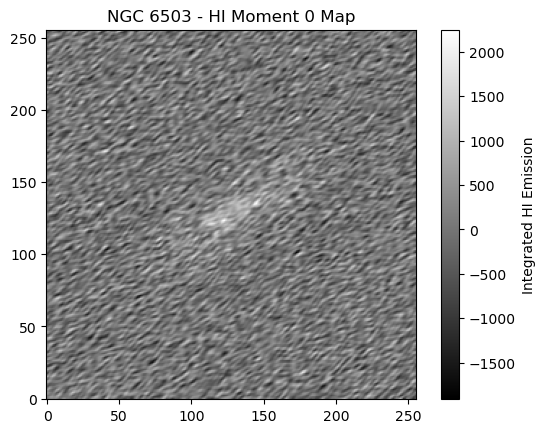

In [49]:
hdul = fits.open('/Users/rileylutz/Downloads/ngc6503.fits', mode='update') 

print('Original CTYPE3:', hdul[0].header.get('CTYPE3', 'Missing')) 
print('Original CUNIT3:', hdul[0].header.get('CUNIT3', 'Missing')) 

hdul[0].header['CTYPE3'] = 'FREQ' 
hdul[0].header['CUNIT3'] = 'Hz' 

hdul.flush() 
hdul.close() 


cube = SpectralCube.read('/Users/rileylutz/Downloads/ngc6503.fits') 

moment0 = cube.moment(order=0) 

fig, ax = plt.subplots() 
plot = ax.imshow(moment0.hdu.data, origin='lower', cmap='gray') 
cbar = fig.colorbar(plot, ax=ax) 
cbar.set_label("Integrated HI Emission") 
ax.set_title("NGC 6503 - HI Moment 0 Map"); 
                                             